# "Classifiez automatiquement des biens de consommation"
_NLP Cleaning Notebook_

In [1]:
import pandas as pd
df = pd.DataFrame()
for i in range (10):
    df['r'+str(i)] = ['u']*20

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [2]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on Colab

In [3]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Mounted at /gdrive
/gdrive
You're on Google Colab


#### Installations and importations required in the virtual environment.

In [4]:
import os
if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
    os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')

In [5]:
!pip install -r requirements_pict.txt

     |████████████████████████████████| 81kB 2.5MB/s 
     |████████████████████████████████| 92kB 6.7MB/s 
     |████████████████████████████████| 276kB 18.8MB/s 
     |████████████████████████████████| 143kB 21.5MB/s 
     |████████████████████████████████| 30.6MB 151kB/s 
     |████████████████████████████████| 25.0MB 67.9MB/s 
     |████████████████████████████████| 1.1MB 51.4MB/s 
  Created wheel for gTTS-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4096 sha256=625fba21f0d3d06059ad55065d72f0864b4b8e22c4660dadea2ba730c959a3fd
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
  Created wheel for marisa-trie: filename=marisa_trie-0.7.5-cp36-cp36m-linux_x86_64.whl size=862365 sha256=6812e2b53a4b1ed66bd42c17a42d9ab4d4bcdc8bcf9a442c50f530f47dea6679
  Stored in directory: /root/.cache/pip/wheels/45/24/79/022624fc914f0e559fe8a1141aaff1f9df810905a13fc75d57
  Created wheel for mwparserfromhell: filename=mwparserfromhell-0.5

In [6]:
from P6_functions import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Installations (creating the requirements file)

In [7]:
!pip install gtts
!pip install wikipedia2vec==0.2.2
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17
!pip install category_encoders
!pip install wikipedia2vec==0.2.2
!pip install utils

In [8]:
# !pip freeze > requirements_pict.txt

#### Importation of modules and packages. 

In [499]:
import io
import sys
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
# import PIL
import cv2
from scipy import ndimage
from scipy.spatial import distance
from math import ceil
import colorsys

from PIL import Image
from IPython.display import Image as ShowImage
from google.colab.patches import cv2_imshow

import copy
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
 davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
 homogeneity_score, completeness_score, v_measure_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
from nltk.stem.snowball import EnglishStemmer
import spacy

# import warnings
# warnings.filterwarnings('ignore')

Setting pandas display options.

In [10]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [11]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [12]:
# speak('Packages and modules successfully imported')

### 0.1 Importing the datasets

Data is composed of :
- one .csv file with descriptions and true categories
- one file of pictures

In [13]:
# importing the categories product names and descriptions
df = pd.read_csv("../DATA/flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')
print("-----> Importation of .csv in the notebook: OK")

df_pict = df[['product_name', 'description']].copy('deep')
df_pict.index = [s+'.jpg' for s in df_pict.index]    

-----> Importation of .csv in the notebook: OK


In [14]:
# --> user 35.2 s, sys: 1.19 s, total: 36.4 s Wall time: 37.5 s
%%time

# to silence the decompression bomb warning
Image.MAX_IMAGE_PIXELS = 1000000000  

file_path = "../DATA/Images/"
li_files = df_pict.index

## importing pictures
dict_img_orig = {}
# loop on the pictures in the file
for i, ind in enumerate(li_files,1):
    print('\r', f"{i}/{len(list(li_files))}", end="")
    # cast each image to a np.array
    img = np.array(Image.open(file_path+ind))
    # put in the dictionnary
    dict_img_orig[ind] = img

 1050/1050CPU times: user 36.6 s, sys: 5.54 s, total: 42.2 s
Wall time: 5min 58s


In [15]:
ser_img_orig = pd.Series(dict_img_orig,
                         index = df_pict.index,
                         name='img_orig')
df_pict = pd.concat([df_pict,
                     ser_img_orig.to_frame()], axis=1)

In [21]:
# speak('Datasets successfully imported')

### 0.2 Categories

In [22]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

# determining the maximum tree depth of categories
ser_depth = df['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max()

def str_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = df['product_category_tree']\
    .apply(lambda s: str_cleaning(s.index, s, name_level_cols))
df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=df_pict.index)

In [23]:
# Put categories in the dataframe

ser_cat = df_cat_level['cat_level_0'].replace({'Home Furnishing': 'Furnishing',
                                               'Baby Care': 'Baby', 
                                               'Watches': 'Watches',
                                         'Home Decor & Festive Needs': 'Decor',
                                         'Kitchen & Dining': 'Kitchen',
                                         'Beauty and Personal Care': 'Beauty',
                                         'Computers': 'Computers'})

df_pict.insert(2, 'category', ser_cat)

### 0.3 Images properties

## FUNCTIONS

#### each individual preprocessing functions

In [24]:
# rgb_to_hsv = np.vectorize(colorsys.rgb_to_hsv)

In [237]:
''' Takes an image, resizes the image and fills the non existing space
with custom color 
'''
import cv2
import numpy as np
from PIL import Image, ImageOps
from PIL.ImageFilter import GaussianBlur

def resize_sq_fill_image(img, sq_size=224, fill_col=(255,255,255),
                 interpolation=Image.ANTIALIAS):
    
    # can be PIL.Image.Image or np.array
    if type(img) == np.ndarray:
        img = Image.fromarray(img)
    elif type(img) == PIL.Image.Image:
        pass
    else:
        print("ERROR: image format unknown, please give np.array or PIL.Image.Image")
    # PIL.Image.Image format from here

    w, h = img.size
    if h != w:
        dif = h if h > w else w
        new_img = Image.new('RGB', (dif, dif), fill_col)
        new_img.paste(img, (int((dif - w) / 2), int((dif - h) / 2)))
        img = new_img
    
    # Change format to np.array and resize with cv2
    new_img = cv2.resize(np.asarray(img), (sq_size, sq_size), interpolation)
    return np.array(new_img)


In [238]:
def equalize_hist(img, clahe_on=False, gridsize=3, clipLimit=2.0):

    if clahe_on:
        clahe = cv2.createCLAHE(clipLimit=clipLimit,
                                tileGridSize=(gridsize,
                                              gridsize))

    if len(img.shape)==3:

        # -> RGB image
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) # RGB to LAB
        lab_planes = cv2.split(lab)
        if clahe_on: # contrast limited adaptative histograme equalizer
            lab_planes[0] = clahe.apply(lab_planes[0])
        else: # simple global histogram equalizer
            lab_planes[0] = cv2.equalizeHist(lab_planes[0])
        lab = cv2.merge(lab_planes)
        new_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) # convert to bgr

    elif len(img.shape)==2:

        # -> grey scale image
        if clahe_on:
            new_img = clahe.apply(img)
        else:
            new_img = cv2.equalizeHist(img)

    return new_img


In [239]:
def apply_threshold(img):

    new_img = copy.deepcopy(img)

    if len(img.shape)==3:
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)

    ret, thresh = cv2.threshold(new_img, 0, 255,
                                cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ## adaptive thershold
    # thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                                cv2.THRESH_BINARY,11,2)
    
    return thresh

In [240]:
def gauss_blur(img, radius): 
    return cv2.GaussianBlur(img, (radius, radius),0)

def med_blur(img, radius):
    return cv2.medianBlur(img, radius)

def rgb_to_grey(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def fast_non_loc_means_denois(img):
    return cv2.fastNlMeansDenoising(img)

In [192]:
image_path = "../DATA/Images/" + df_pict.index[-3]
img = cv2.imread(image_path)

In [193]:
img_grey = rgb_to_grey(img)

In [218]:
thresh = apply_threshold(img)

In [ ]:
cv2_imshow(thresh)

In [ ]:
# def sift_extract():
#     sift = cv2.xfeatures2d.SIFT_create()
#     kp, desc = sift.detectAndCompute(img_orig, None)
#     # f, ax = plt.subplots(figsize = (15, 8))
#     # ax.imshow(cv2.drawKeypoints(img_orig, kp, img_orig.copy()))
#     # plt.show()

In [ ]:
'''
tester clahe avec une image noir et blanc et avec une image couleur
tester est-ce qu'une image est noir et blanc ou couleur
appliquer la bonne séquence
'''

#### preproc_image

In [481]:
''' Takes an image and apply a chosen sequence of transformations
'''

import cv2
import numpy as np
from PIL import Image

def preproc_image(img, list_preproc_tup): # {'list_preproc_tup': xxxx}

    new_img = copy.deepcopy(img)
    dict_transf = {'resize': resize_sq_fill_image,
                   'gauss_bl': gauss_blur,
                   'med_bl': med_blur,
                   'rgb_to_grey': rgb_to_grey,
                   'nl_denois': fast_non_loc_means_denois,
                   'equalize' : equalize_hist,
                   'thresh': apply_threshold,
                   }

    for name, dict_params in list_preproc_tup:
        new_img = dict_transf[name](new_img, **dict_params)

    return np.array(new_img)

#### show_img_and_hist

In [448]:
'''
Show one image through specific preproc function and preproc params
'''
def show_img_and_hist(img_orig=None, img=None, rgb_hist_on=True, figsize=(8,4),
                      preproc_func=None, preproc_params=None):

    # if img_orig -> preproc to apply
    if img_orig is not None:
        fig = plt.figure(figsize=figsize)
        ax1, ax2, ax3, ax4  = fig.add_subplot(221),\
                                fig.add_subplot(222),\
                                fig.add_subplot(223),\
                                fig.add_subplot(224)

        if preproc_func is None:
            print("BEWARE, no preprocessing function was given")
        img = preproc_func(img_orig, **preproc_params)
                            
        ax1.imshow(img_orig, cmap='gray')
        ax3.imshow(img, cmap='gray')
        
        if rgb_hist_on and len(img_orig.shape)==3:
        # Show the 3 histograms (rgb)
            for i, col in enumerate(['r', 'g', 'b']):
                ax2.hist(img_orig[:,:,i].flatten(), bins=range(256),
                            color=col, alpha = 0.5, zorder=10)
        if rgb_hist_on and len(img.shape)==3:
        # Show the 3 histograms (rgb)
            for i, col in enumerate(['r', 'g', 'b']):
                ax4.hist(img[:,:,i].flatten(), bins=range(256),
                            color=col, alpha = 0.5, zorder=10)
        # show global histogram
        ax2.hist(img_orig.flatten(), bins=range(256), color='dimgrey')
        ax4.hist(img.flatten(), bins=range(256), color='dimgrey')

        ax1.set_title('Original image')
        ax2.set_title('Original histogram')
        ax3.set_title(f'Image after preprocessing')
        ax4.set_title(f'Histogram after preprocessing')

    else: # show img only

        if img is not None:
            fig = plt.figure(figsize=figsize)
            ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
            ax1.imshow(img, cmap='Greys_r')
        else:
            print("ERROR: No image given at all !!!")
        
        if rgb_hist_on and len(img.shape)==3:
        # Show the 3 histograms (rgb)
            for i, col in enumerate(['r', 'g', 'b']):
                ax2.hist(img[:,:,i].flatten(), bins=range(256),
                            color=col, alpha = 0.5, zorder=10)
        # show only global histogram
        ax2.hist(img.flatten(), bins=range(256), color='dimgrey')

        ax1.set_title(f'Image')
        ax2.set_title(f'Histogram')

    plt.tight_layout()
    plt.show()

#### print_thumbnails_from_df

In [449]:
''' can be used to test preprocessing on representative samples
of each category
'''

def print_thumbnails_from_df(ser_pict, li_files, preproc_func=None,
                             preproc_params=None, n_rows=1,
                             figsize=(15,2), fig=None, title=None):

    n_tot = len(li_files)
    n_cols = (n_tot//n_rows)+((n_tot%n_rows)>0)*1
    fig = plt.figure(figsize=figsize) if fig is None else fig
    for i, ind in enumerate(li_files,1):
        img = ser_pict.loc[ind]
        if preproc_func is not None:
            img = preproc_func(img, **preproc_params)
        ax = fig.add_subplot(n_rows,n_cols,i)
        if len(img.shape)==3:
            ax.imshow(img)
        else:
            ax.imshow(img, cmap='Greys_r')
        ax.set_axis_off()
        if title is not None:
            plt.suptitle(title, fontweight='bold')
    plt.show()

#### print_sample_by_from_df

In [450]:
def print_sample_by_from_df(ser_pict, sercat, n_img=10, n_rows=1,
                            preproc_func=None, preproc_params=None,
                            figsize=(20,2)):

    gb = ser_pict.groupby(sercat)
    for name, sub_df in gb:
        li_files = sub_df.sample(n_img).index
        print_thumbnails_from_df(ser_pict, li_files,
                                 preproc_func,
                                 preproc_params,
                                 n_rows=n_rows,
                                 figsize=figsize,
                                 title=name)

## 1 Exploratory analysis

### 1.1 Browsing images prior to preprocessing

In [ ]:
## Doesn't work on Colab...
# from easyimages import EasyImageList
# Li = EasyImageList.from_folder("../DATA/Images/")
# Li.symlink_images()
# Li.html(sample=10, size=44)

#### thumbnails

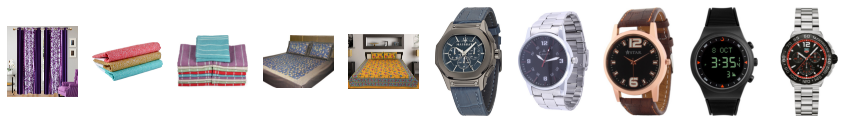

In [451]:
print_thumbnails_from_df(df_pict['img_orig'],
                         df_pict.index[0:10],
                         n_rows=1, figsize=(15,2))

#### thumbnails by categories

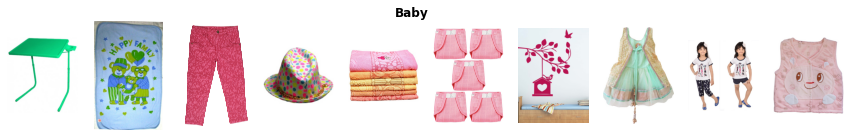

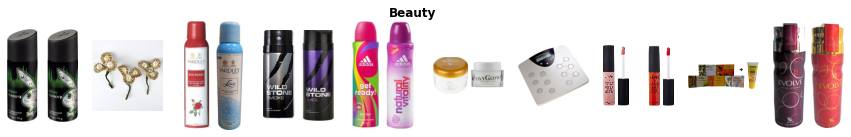

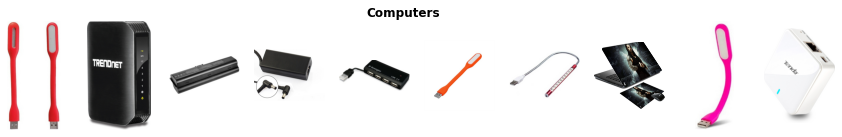

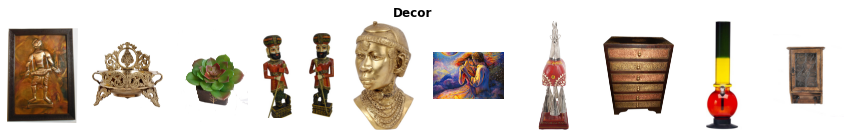

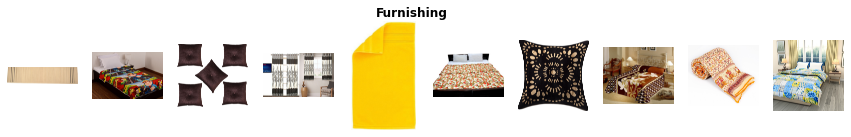

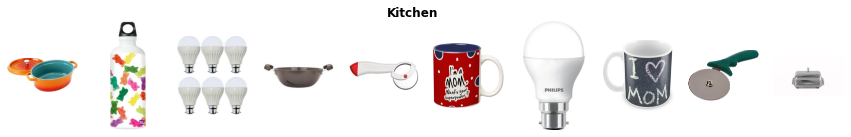

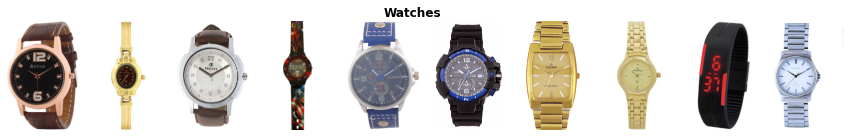

In [452]:
print_sample_by_from_df(df_pict['img_orig'], df_pict['category'],
                        n_img=10, n_rows=1, figsize=(15,2))

## 2 Image pre-processing

### 2.0 Browsing with preprocessing

 #### One image

In [453]:
# pick an image
image_path = "../DATA/Images/"+df_pict.index[-1]
img = cv2.imread(image_path)

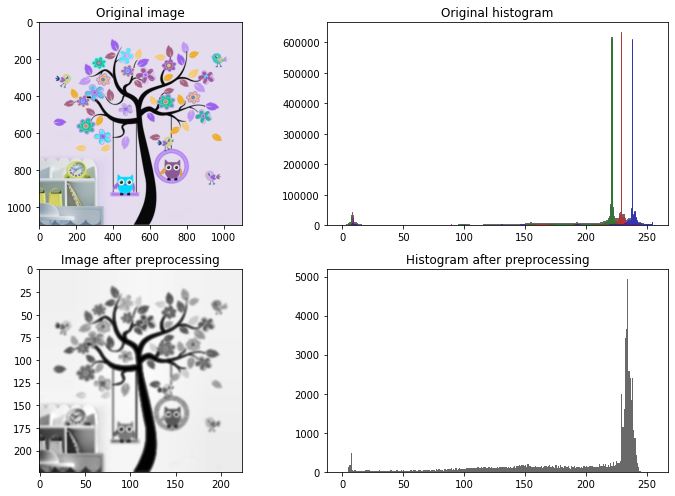

In [454]:
# Show the effect of a sequence of transformations on one image

list_preproc_tup = [('resize', {'sq_size': 224, 
                                'fill_col': (255,255,255),
                                'interpolation': Image.ANTIALIAS}),
                    ('gauss_bl', {'radius': 5}),
                    ('rgb_to_grey', {}),
                    ('equalize', {'clahe_on': True,
                                  'gridsize': 3,
                                  'clipLimit': 2.0}),
                    # ('thresh', {})
                    ]

# mod_img = preproc_image(img, **{'list_preproc_tup': list_preproc_tup})
show_img_and_hist(img_orig=img, img=None, rgb_hist_on=True, figsize=(10,7),
                  preproc_func=preproc_image,
                  preproc_params={'list_preproc_tup': list_preproc_tup})

#### Thumbnails

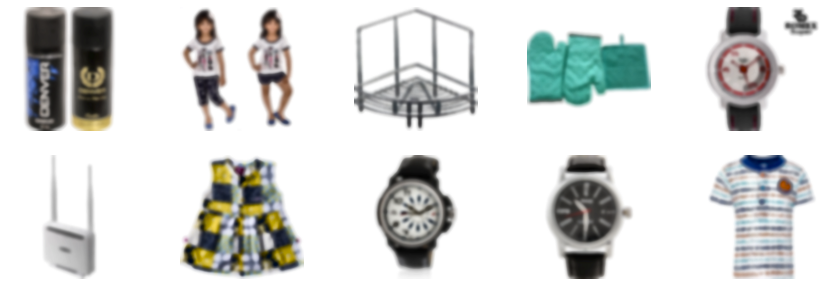

In [460]:
# Apply a preprocessing on the fly and shows the result (sample)

list_preproc_tup = [('resize', {'sq_size': 224, 
                                'fill_col': (255,255,255),
                                'interpolation': Image.ANTIALIAS}),
                    ('gauss_bl', {'radius': 17}),
                    ('equalize', {'clahe_on': True,
                                  'gridsize': 3,
                                  'clipLimit': 2.0}),
                    # ('thresh', {})
                    ]
ind_samp = df_pict.sample(10).index
print_thumbnails_from_df(df_pict['img_orig'],
                         ind_samp,
                         preproc_func=preproc_image,
                         preproc_params={'list_preproc_tup': list_preproc_tup},
                         n_rows=2, figsize=(15,5))

#### Thumbnails by categories

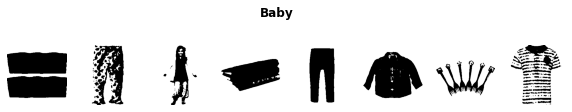

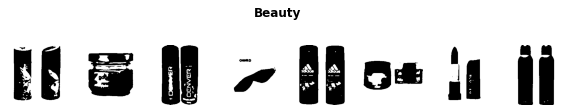

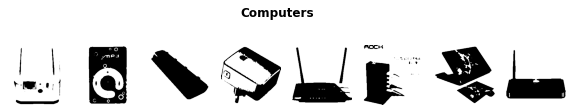

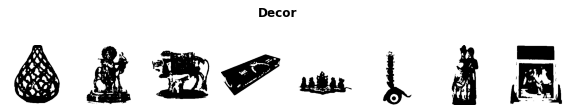

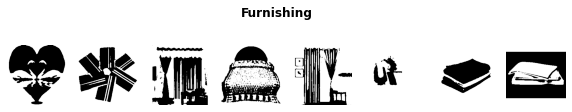

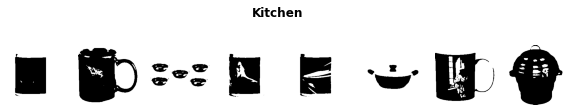

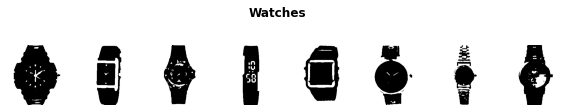

In [355]:
# Apply a preprocessing on the fly and shows the result (sample by categories)

list_preproc_tup = [('resize', {'sq_size': 224, 
                                'fill_col': (255,255,255),
                                'interpolation': Image.ANTIALIAS}),
                    ('gauss_bl', {'radius': 5}),
                    ('equalize', {'clahe_on': True,
                                  'gridsize': 3,
                                  'clipLimit': 2.0}),
                    ('thresh', {})]

print_sample_by_from_df(df_pict['img_orig'], df_pict['category'], n_img=8, n_rows=1,
                        preproc_func=preproc_image,
                        preproc_params={'list_preproc_tup': list_preproc_tup},
                        figsize=(10,2))

### 2.1 Applying preprocessing to all the images

#### creating a list of preprocessings

In [461]:
# preproc 1 ("img_color") COLOR 224 - color - blur3 - claheeq
p_color = [('resize', {'sq_size': 224, 
                             'fill_col': (255,255,255),
                             'interpolation': Image.ANTIALIAS}),
           ('gauss_bl', {'radius': 3}),
           ('equalize', {'clahe_on': True,
                         'gridsize': 3,
                         'clipLimit': 2.0})]

In [462]:
# preproc 2 ("img_not_eq") NOT EQUALIZED 224 - color - blur3
p_not_eq = [('resize', {'sq_size': 224, 
                        'fill_col': (255,255,255),
                        'interpolation': Image.ANTIALIAS}),
            ('gauss_bl', {'radius': 3})]

In [463]:
# preproc 3 ("img_not_blur") NOT BLURRED 224 - color - claheeq
p_not_blur = [('resize', {'sq_size': 224, 
                          'fill_col': (255,255,255),
                          'interpolation': Image.ANTIALIAS}),
             ('equalize', {'clahe_on': True,
                           'gridsize': 3,
                           'clipLimit': 2.0})]

In [490]:
# preproc 4 ("img_grey") GREY 224 - grey - blur3 - claheeq
p_grey = [('resize', {'sq_size': 224, 
                      'fill_col': (255,255,255),
                      'interpolation': Image.ANTIALIAS}),
          ('rgb_to_grey', {}),
          ('gauss_bl', {'radius': 3}),
          ('equalize', {'clahe_on': True,
                        'gridsize': 3,
                        'clipLimit': 2.0})]

In [465]:
# preproc 5 ("img_small") SMALL 112 - color - blur3 - claheeq
p_small = [('resize', {'sq_size': 112, 
                       'fill_col': (255,255,255),
                       'interpolation': Image.ANTIALIAS}),
           ('gauss_bl', {'radius': 3}),
           ('equalize', {'clahe_on': True,
                         'gridsize': 3,
                         'clipLimit': 2.0})]

In [466]:
# preproc 6 ("img_big") BIG 448 - color - blur3 - claheeq
p_big = [('resize', {'sq_size': 448,
                     'fill_col': (255,255,255),
                     'interpolation': Image.ANTIALIAS}),
          ('gauss_bl', {'radius': 3}),
          ('equalize', {'clahe_on': True,
                        'gridsize': 3,
                        'clipLimit': 2.0})]

In [467]:
# preproc 7 ("img_thresh") THRESH 224 - color - blur3 - claheeq - thresh
p_thresh = [('resize', {'sq_size': 224, 
                                'fill_col': (255,255,255),
                                'interpolation': Image.ANTIALIAS}),
                    ('gauss_bl', {'radius': 3}),
                    ('equalize', {'clahe_on': True,
                                  'gridsize': 3,
                                  'clipLimit': 2.0}),
                    ('thresh', {})]

In [493]:
df_pict.columns

Index(['product_name', 'description', 'category', 'img_orig', 'img_RS50_maxpool_fl',
       'img_preproc_1', 'img_color', 'img_not_eq', 'img_not_blur', 'img_grey', 'img_small',
       'img_big', 'img_thresh'],
      dtype='object')

In [495]:
## Applique un traitement et store dans la dataframe

li_preproc_params = [
                     ('img_color', p_color),
                     ('img_not_eq', p_not_eq),
                     ('img_not_blur', p_not_blur),
                     ('img_grey', p_grey),
                     ('img_small', p_small),
                     ('img_big', p_big),
                     ('img_thresh', p_thresh)
                     ]
                     
for n_prep_params, prep_params in li_preproc_params:
    print('\n', n_prep_params)
    dict_trans = {}
    for i, ind in enumerate(df_pict.index, 1):
        print('\r', f"{i}/{df_pict.shape[0]}", end='')
        dict_trans[ind] = preproc_image(df_pict['img_orig'].loc[ind],
                                        list_preproc_tup=prep_params)
    ser_pict = pd.Series(dict_trans)
    df_pict[n_prep_params] = ser_pict.to_frame()


 img_color
 1050/1050
 img_not_eq
 1050/1050
 img_not_blur
 1050/1050
 img_grey
 1050/1050
 img_small
 1050/1050
 img_big
 1050/1050
 img_thresh
 1050/1050

In [ ]:
# p_tiny = [('resize', {'sq_size': 80, 
#                       'fill_col': (255,255,255),
#                       'interpolation': Image.ANTIALIAS})]

# test = preproc_image(img=df_pict['img_orig'].iloc[-89],
#                      list_preproc_tup=p_tiny)
# cv2_imshow(test)

#### Checking thumbnails

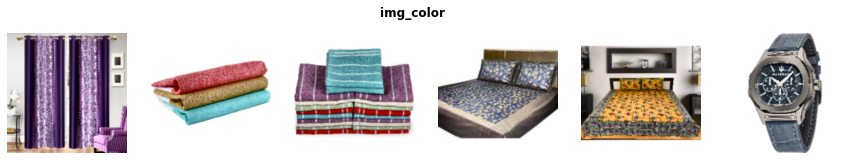

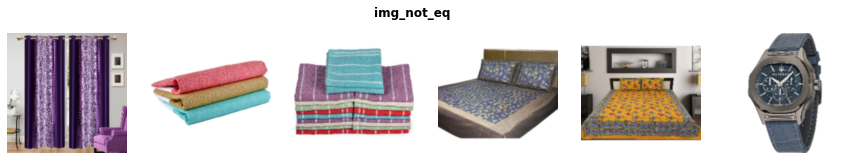

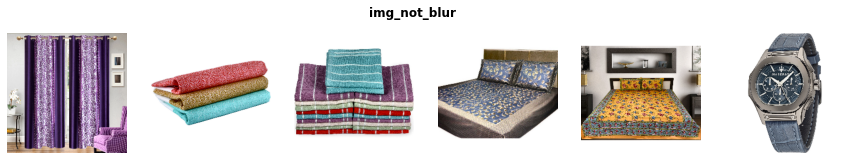

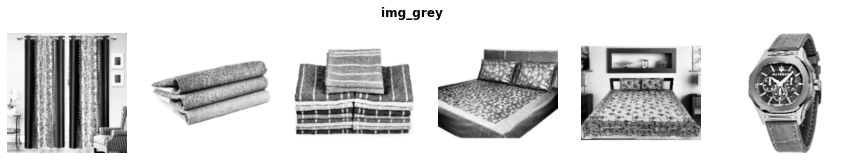

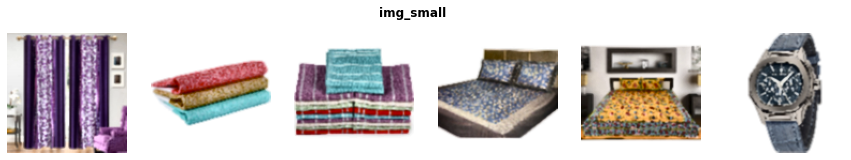

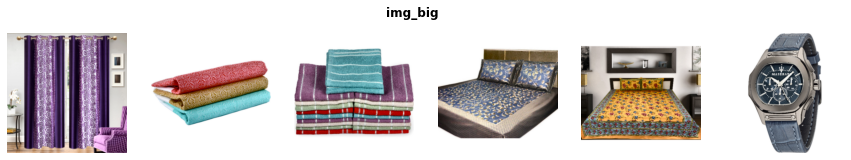

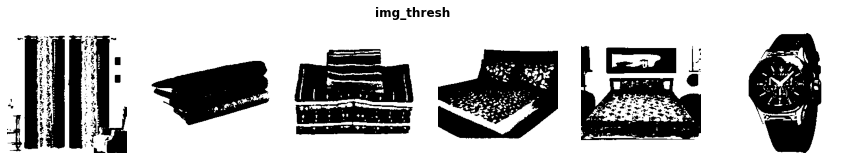

In [496]:
li_n_preproc = ['img_color', 'img_not_eq', 'img_not_blur', 'img_grey',
                'img_small', 'img_big', 'img_thresh']
for n_preproc in li_n_preproc:
    print_thumbnails_from_df(df_pict[n_preproc],
                             df_pict.index[0:6],
                             n_rows=1, figsize=(15,2.5),
                             title=n_preproc)

#### Checking thumbnails by categories

In [ ]:
# # Show the preprocessed images already stored in the dataframe by preprocessing

# print_sample_by_from_df(df_pict['img_grey'], df_pict['category'],
#                         n_img=5, n_rows=1, figsize = (10,2))

### 2.2 Stores the result in a pickle

In [36]:
# import dill
# dill.dump(dict_images, open('dict_images.pkl', mode='wb'))

In [37]:
# import dill
# df_pict = dill.load(open('df_pict.pkl', mode='rb'))
# dict_images = dill.load(open('dict_images.pkl', mode='rb'))

## 3 GridSearch optimisation

In [497]:
df_res_clust = pd.DataFrame()
df_res_clust['category'] = df_pict['category']

### 3.1 Preprocessing, dimension reduction and clustering on pixel matrices

In [509]:
'''
Class to get from the big dataframe df_pict (containing all
the preprocessed images) one series of preprocessed images (column : n_col_img)
and unfold the data to get a dataframe with each pixel as a column
'''

class GetImageFromDf(BaseEstimator, TransformerMixin):

    def __init__(self, n_col_img=None):
        self.n_col_img = n_col_img

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None): # X is the big df_pict dataframe
        # get the dataframe with flattened pixels values corresponding to n_col_img
        ser_list = X[self.n_col_img].apply(lambda x: x.flatten())
        X_df = pd.DataFrame.from_dict(dict(zip(ser_list.index,
                                               ser_list.values))).T
        return X_df

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [519]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([('imggetter', GetImageFromDf()), # Preprocessed Images getter
                 ('dimreduc', PCA(random_state=14)), # Dimension reductor
                 ('clusterer', KMeans(random_state=14))]) # KMeans clusterer

# Define the list of params to be tested in the GridSearchClust
param_grid = {'imggetter__n_col_img': ['img_color', 'img_not_eq',
                                       'img_not_blur', 'img_grey',
                                       'img_small', 'img_big', 'img_thresh'],
              'dimreduc': [PCA(random_state=14), 
                           LDA(random_state=14),
                           NMF(random_state=14),
                           TruncatedSVD(random_state=14),
                        #    TSNE_wrapper(random_state=14),
                           UMAP(random_state=14)],
              'dimreduc__n_components': [2,5,7,10,20,50,100,500],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_pict['category'],
                      refit='ari',
                      greater_is_better=True) # for the refit_score

In [ ]:
##### Perform the grid search
gsc.fit(df_pict, verbose=True);

 50/280:

In [ ]:
### Pickling the results
import dill as pickle
with open('P01_gsc_preproc_dimred_km.pkl', 'wb') as file:
    pickle.dump(gsc, file)

In [ ]:
# ### Loading the results
# import dill as pickle
# with open('P01_gsc_preproc_dimred_km.pkl', 'rb') as file:
#     gsc = pickle.load(file)

In [513]:
# Display results (products name) A REMPLACER

print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
# Best hyperparameters: {'clusterer__n_clusters': 7, 'dimreduc': UMAP(a=None, angular_rp_forest=False, b=None,
#      force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
#      local_connectivity=1.0, low_memory=False, metric='euclidean',
#      metric_kwds=None, min_dist=0.1, n_components=7, n_epochs=None,
#      n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
#      output_metric_kwds=None, random_state=14, repulsion_strength=1.0,
#      set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
#      target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
#      transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False), 'dimreduc__n_components': 7, 'imggetter__n_col_img': 'img_color'}
# Best refit score: 0.13789613579133495

-----Product name
Best hyperparameters: {'clusterer__n_clusters': 7, 'dimreduc': UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=7, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=14, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False), 'dimreduc__n_components': 7, 'imggetter__n_col_img': 'img_color'}
Best refit score: 0.13789613579133495


Plotting the results of the clustering optimization

In [ ]:
# Compute the dataframe showing the results depending on one parameter
#(other parameters set tot best_params_)

best_params, df_sel_scores, df_gsclust_filt, df_res = \
            filters_gsclust_results(gsc, 'imggetter__n_col_img',
                                    return_df_res=True)
df_sel_scores

In [ ]:
# Plotting the graphs of the clustering scores with best refit score (line)

plot_gsc_multi_scores(gsc=gsc, param='dimreduc__n_components', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))


In [ ]:
# Effect of 2 parameters on clustering scores

params1 = ['imggetter__n_col_img', 'dimreduc']
params2 = ['dimreduc', 'dimreduc__n_components']
params3 = ['dimreduc__n_components', 'imggetter__n_col_img']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc, params=params1, shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc, params=params2, shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc, params=params3, shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

In [ ]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(20,4))
params = ['imggetter__n_col_img', 'dimreduc']

scores = ['ari', 'homog', 'complet', 'v_meas']
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc, params=params, fmt='.2f',
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

Storing the results of the best model

In [ ]:
# # Storing labels of the best model in a dataframe

# model = gsc.best_estimator_.set_params(**gsc.best_params_)\
#   .set_params(**{'clusterer__random_state': 14})
# df_res_clust['p0_umap100_km'] = \
#                 model.predict(df_pict)
# df_res_clust['p0_umap100_km'].shape

(1050,)

In [44]:
# # Appending the best results of the Kmeans clustering
# df_res_clust['p0_umap100_km'] = XXXX

In [ ]:
# # Computing the best preprocessed dataset prior to clustering
# # model_sm = Pipeline(model.steps[0:-1]) # TEMPORAIRE A REPARER
# dict_best_df['01_preproc_km'] = \
#         model_sm.transform(df_pict)
# dict_best_df['01_preproc_km'].shape

In [ ]:
# ### Pickling the best preprocessed dataset prior to clustering
# import dill as pickle
# with open('dict_best_df.pkl', 'wb') as file:
#     pickle.dump(dict_best_df, file)

### 3.2 Clustering on a bag of visual words (SIFT, SURF, ORB)

In [46]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

#### Extracts local features from images

The below function returns an array whose first index holds a list that holds all local features from all images without an order. This is our visual dictionary. And the second index holds the sift vectors dictionary which holds the descriptors but this is separated class by class

In [47]:
# Creates descriptors using sift 
# Takes one parameter that is images dictionary
# Return an array whose first index holds the decriptor_list without an order
# And the second index holds the sift_vectors dictionary which holds
# the descriptors but this is seperated class by class

def sift_features(images):
    dict_sift_descriptors, dict_keypoints = {}, {}
    all_descriptors_list = []
    sift = cv2.xfeatures2d.SIFT_create()
    for key,img in images.items():
        features = []
        kp, des = sift.detectAndCompute(img,None)
        all_descriptors_list.extend(des)
        dict_sift_descriptors[key] = des
        dict_keypoints[key] = kp
    return dict_keypoints, dict_sift_descriptors, all_descriptors_list

# def get_descriptors(image_path):
#     # load image and convert it to grayscale
#     img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     # detect key points and descriptors
#     keypoints, descriptors = model.detectAndCompute(img_gray, None)
#     # returns keypoints and descriptors
#     return keypoints, descriptors

In [ ]:
# Store descriptors and bovw features 
# keypoints_list, descriptor_list, all_bovw_feature = sift_features(dict_images) 
dict_keypoints, dict_sift_descriptors, all_descriptors_list = \
                                             sift_features(dict_images) 

In [ ]:
# import dill
# dill.dump((dict_sift_descriptors, all_descriptors_list),
#           open("descriptors.pkl", "wb"))

In [ ]:
import dill
dict_sift_descriptors, all_descriptors_list  = \
    dill.load(open("descriptors.pkl", "rb"))

In [ ]:
# print("list of the keypoints", len(keypoints_list))
print("list of all the descriptors: ", len(all_descriptors_list))
print("dictionary giving all the descriptors (vectors) for each image: ",
      len(dict_sift_descriptors.keys()))

#### Selects the visual words

Send the visual dictionary to the k-means clustering algorithm and find the visual words which are center points.

In [ ]:
# A k-means clustering algorithm who takes 2 parameter which is number 
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.

from sklearn.cluster import KMeans

def descriptors_cluster_centers(k, descriptors_list):
    clusterer = KMeans(n_clusters = k, n_init=10)
    clusterer.fit(descriptors_list)
    visual_words = clusterer.cluster_centers_ 
    return visual_words, clusterer

In [ ]:
# # Takes the central points which is visual words   

# visual_words, desc_clusterer = descriptors_cluster_centers(150,
#                                                            all_descriptors_list)
# visual_words.shape

In [ ]:
# import dill
# dill.dump((visual_words, desc_clusterer), open("visual_words.pkl", "wb"))

In [ ]:
import dill
visual_words, desc_clusterer = dill.load(open("visual_words.pkl", "rb"))

In [ ]:
# détermine pour chaque image a quel cluster appartient les descripteurs
# renvoie un dictionnaire avec la liste des numéros des clusters parmi 150
# convertit le dictionnaire en pd.Series, puis en dataframe (multilabelbinarizer)
vw_list = []
ind_img_list = []
for n_img, desc_list in dict_sift_descriptors.items():
    vwords = desc_clusterer.predict(desc_list) # liste des numéros des visuals words de l'image
    vw_list.append(vwords) # liste des listes de vw pour toutes les images
    ind_img_list.append(n_img) # liste des index des images

In [ ]:
from collections import Counter
df_visual_words = pd.DataFrame([Counter(x) for x in vw_list],
                               index = ind_img_list).fillna(0)
df_visual_words = df_visual_words[sorted(df_visual_words.columns)]

In [ ]:
df_visual_words

#### KMeans clustering on the BoVW

In [ ]:
# Data selection to train clusterer (HSV 224x224 pixels)
X_df = df_visual_words
print("Size of the training data :", X_df.shape)

In [ ]:
# Visualization of the images (BoVW of 150 VW) on a t-SNE projection

ser_categories = pd.Series(df_pict['category'].values, 
                           index=df_pict.index,
                           name='Clust')

plot_projection(X_df, model=None, ser_clust=ser_categories,
                proj='t-SNE', size=10, legend_on=True,
                title="Projection t-SNE of the pictures\n(Bag of 150 VirtualWords)",
                figsize=(10, 6), palette='tab10',
                fig=None, ax=None, random_state=14)

In [ ]:
# Create the model
from sklearn.cluster import KMeans
k=7 # number of categories
km = KMeans(n_clusters=k) 

In [ ]:
# Fitting the Kmeans model
km.fit(X_df)

In [ ]:
# Appending the best results of the Kmeans clustering
df_res_clust['KMclust_Bo150VW'] = km.labels_

In [ ]:
df_res_clust.sample(5)

### 3.3 Feature extraction using transfer learning

#### VGG16

In [ ]:
# from keras.applications import VGG16

# conv_base = VGG16(weights='imagenet',
#                  include_top=False,
#                  input_shape=(150,150,3))

# conv_base.summary()

#### ResNet50

In [122]:
from keras import applications

# getting the convolutional base of a ResNet50 CNN 
resnet50_conv_base = applications.resnet50.ResNet50(
    weights='imagenet',
    include_top=False, # remove the last layer
    input_shape=(224,224,3)
)

94773248/94765736 [==============================] - 1s 0us/step


In [123]:
### Creation of the cnn model to extract features

from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D
from keras.layers import Flatten

# add resnet50 convolutional base to our model
cnn_model = Sequential()
cnn_model.add(resnet50_conv_base)

# add layer for dimensional reduction (global max pooling) 
cnn_model.add(GlobalMaxPooling2D())
# add layer for flattening
cnn_model.add(Flatten())

# print summary of the model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [124]:
# loop on each product
features = []
for img in df_pict['img_preproc_1']:
    
    # reshape img (np.array) to get a tensor
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    
    # get the extracted features
    features.append(cnn_model.predict(img).reshape(-1))
    
ser_feat = pd.Series(features,
                     index=df_pict.index)

In [125]:
df_pict['img_RS50_maxpool_fl'] = ser_feat

In [126]:
# for ResNet50 features, get a dataframe with features for each item
ser_list = df_pict['img_RS50_maxpool_fl']
X_df = pd.DataFrame.from_dict(dict(zip(ser_list.index, ser_list.values))).T
X_df.shape

(1050, 2048)

In [127]:
# dimension reduction
from umap import UMAP
umap = UMAP(n_components=100)
X_proj = pd.DataFrame(umap.fit_transform(X_df),
                      index=df_pict.index)
X_proj.shape

(1050, 100)

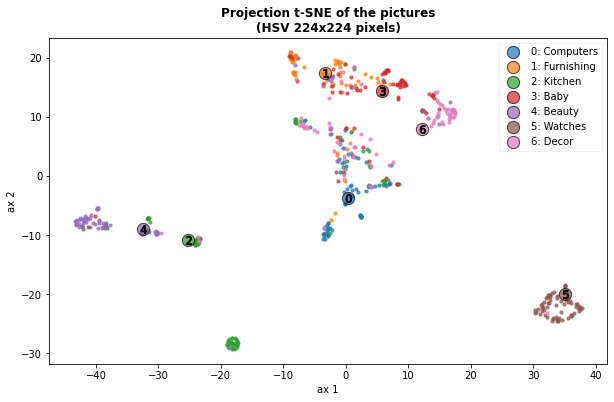

In [128]:
# Visualization of the images (HSV 224 x 224 x 3 pixels) on a t-SNE projection

ind_samp = X_proj.sample(500).index
plot_projection(X_proj.loc[ind_samp], model=None,
                ser_clust=df_pict['category'].loc[ind_samp],
                proj='t-SNE', size=10, legend_on=True,
                title="Projection t-SNE of the pictures\n(HSV 224x224 pixels)",
                figsize=(10, 6), palette='tab10',
                fig=None, ax=None, random_state=14)

In [129]:
# Create the model
from sklearn.cluster import KMeans
k=7 # number of categories
km = KMeans(n_clusters=k) 

In [130]:
# Fitting the Kmeans model
km.fit(X_proj)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [131]:
# Appending the best results of the Kmeans clustering
df_res_clust['img_RS50_maxpool_fl'] = km.labels_

In [132]:
df_res_clust.sample(5)

,category,img_RS50_maxpool_fl
e40e9b4ae48e452dc407d299b467d0c3.jpg,Baby,4
5fdb912462da9891e5b21c677ceb15e4.jpg,Decor,4
baa093d149982b010ab72ecbeec6110f.jpg,Kitchen,4
c109187e7975ee8fdb2b3dfbdd9dce20.jpg,Decor,4
3fd4d7ea04624ada39fde3957c7b9b7c.jpg,Decor,4


## 4 Comparison of clusters labels with true categories

#### Comparison between scores...

In [ ]:
# # Comparison of clusters labels with true categories

# from sklearn.metrics import adjusted_rand_score

# ser_ari_pairs_models = comp_clust_metrics_col_pairs(df_res_clust,
#                                                     first_vs_others=True,
#                                                     print_opt=False,
#                                                     n_score='ari')

# # Plotting the results

# fig = plt.figure(figsize=(3,3))
# ser_ari_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
# plt.ylabel('ARI score')
# # plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# # plt.gca().set(ylim=(0.85,1))
# plt.show()

#### Matching scores (true categories vs. clusters)

In [133]:
df_res_clust.columns

Index(['category', 'img_RS50_maxpool_fl'], dtype='object')

In [134]:
ser_pairs_models = comp_clust_metrics_col_pairs(df_res_clust,
                                                first_vs_others=True,
                                                n_score='ari',
                                                print_opt=True)

--- ari between first and the 1 others ---
ari: mean=0.372, std=0.000, min=0.372, max=0.372 


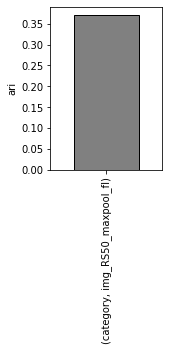

In [140]:
fig = plt.figure(figsize=(2,3))
ser_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
plt.ylabel('ari')
# plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# plt.gca().set(ylim=(0.85,1))
plt.show()

#### Confusion matrix

In [136]:
cat_clust_confmat = confusion_matrix_clust(df_res_clust['category'],
                                           df_res_clust['img_RS50_maxpool_fl'],
                                           normalize=False,
                                           margins_sums=True,
                                           margins_score=True)
with pd.option_context('display.float_format', '{:.0f}'.format):
    display(cat_clust_confmat)

img_RS50_maxpool_fl,4,1,6,5,0,3,2,cat_sum,cat_matching_score_pct
category,,,,,,,,,
Baby,70,5,1,18,56,0,0,150,47
Beauty,5,113,3,14,14,1,0,150,75
Computers,0,3,67,67,13,0,0,150,45
Decor,81,3,2,22,40,0,2,150,15
Furnishing,2,0,2,10,136,0,0,150,91
Kitchen,25,12,1,29,28,55,0,150,37
Watches,2,4,0,4,1,0,139,150,93
clust_sum,185,140,76,164,288,56,141,1050,-
clust_matching_score_pct,38,81,88,13,47,98,99,-,-


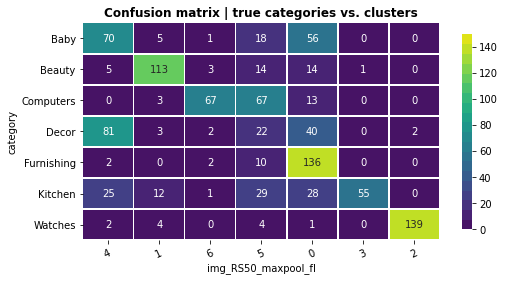

In [141]:
cm = confusion_matrix_clust(df_res_clust['category'],
                            df_res_clust['img_RS50_maxpool_fl'],
                            normalize=False,
                            margins_sums=False,
                            margins_score=False)
plot_heatmap(cm, "Confusion matrix | true categories vs. clusters",
             figsize=(8, 4), vmin=0, vmax=150, center=75,
                 palette=sns.color_palette("viridis", 20), shape='rect',
                 fmt='.0f', robust=False, fig=None, ax=None)

####  Sankey confusion diagram

In [138]:
# to get interactive graph
plot_sankey_confusion_mat(cm, static=False, font_size=14)

In [ ]:
# # # to get interactive graph
# # plot_sankey_confusion_mat(cm, static=False, font_size=14)

# # to get static graph static
# import plotly.graph_objects as go
# from IPython.display import Image

# img_bytes = plot_sankey_confusion_mat(cm, static=True, font_size=18,
#                                       figsize=(2, 1.7), scale = 1)
# Image(img_bytes)

#### 2D visualisation

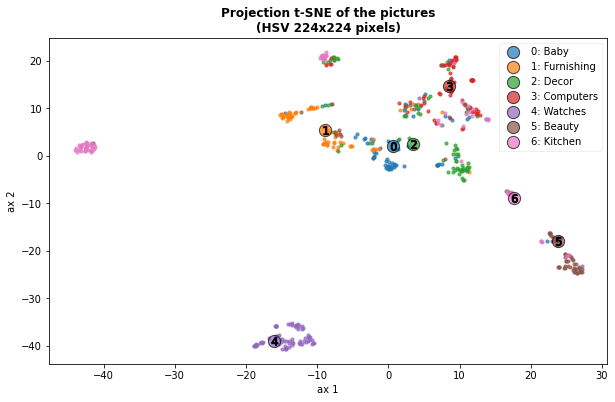

In [498]:
# Visualization of the images (HSV 224 x 224 x 3 pixels) on a t-SNE projection

ind_samp = X_proj.sample(500).index
plot_projection(X_proj.loc[ind_samp], model=None,
                ser_clust=df_pict['category'].loc[ind_samp],
                proj='t-SNE', size=10, legend_on=True,
                title="Projection t-SNE of the pictures\n(HSV 224x224 pixels)",
                figsize=(10, 6), palette='tab10',
                fig=None, ax=None, random_state=14)

In [ ]:
# Plotting a projection of the points (true categories vs. clusters) (PCA 0.71, UMAP 0.81, t-SNE 0.83)

ind_samp = df_res_clust.sample(300, random_state=14).index
plot_projection_cat_clust(\
        dict_best_df['04b_USE_dimred_km'].loc[ind_samp], model=None,
        ser_clust=df_res_clust['04b_USE_dimred_km'].loc[ind_samp], # clustering already done
        true_cat=df_res_clust['categories'].loc[ind_samp], # true categories
        proj='UMAP', tw_n_neigh=3, 
        size=45, edgelinesize=2.5, legend_on=True,
        title="True categories vs. Clusters ( BOW -> t-SNE )",
        figsize=(8, 5), palette='tab10',
        fig=None, ax=None, random_state=14, bboxtoanchor=(1,1))